In [1]:
#!pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
#!pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
#!pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
#!pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil # shutil not used
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
from pathlib import Path

import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold # only StratifiedGroupKFold used

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda import amp

import albumentations as A

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import segmentation_models_pytorch as smp
import wandb

In [4]:
os.makedirs('experiments', exist_ok=True)

In [5]:
log_path = "experiments/exp{}/".format(
        str(len([i for i in os.listdir("experiments/") if i.startswith("exp")]) + 1)
    )
os.makedirs(log_path)

In [6]:
class CFG:
    seed = 101
    debug = False 
    exp_name = 'Baseline'
    comment = 'timm-mobilenetv3_large_100-224x224'
    model_name = 'UnetPlusPlus'
    backbone = 'timm-mobilenetv3_large_100'
    project_name = "uw-segmentation"
    team_name = "cv-itmo"
    train_bs = 32
    valid_bs = train_bs
    img_size = [224, 224]
    epochs = 10
    lr = 2e-3
    scheduler = 'ReduceLROnPlateau'
    min_lr = 1e-6
    T_max = int(30000/train_bs*epochs)+50
    T_0 = 25
    warmup_epochs = 0
    wd = 1e-6
    n_accumulate = max(1, 32//train_bs)
    n_fold = 5
    num_classes = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    thr = 0.45
    log_path = log_path
    wandb_logging = True

In [7]:
CFG.log_path

'experiments/exp1/'

In [8]:
if CFG.wandb_logging:
    wandb.init(
            project=CFG.project_name,
            name=CFG.comment,
            entity=CFG.team_name,
            config={
                "server": 'own server',
                "experiments": CFG.log_path,
                "epochs": CFG.epochs,
                "batch_size": CFG.train_bs,
                "model name": CFG.model_name,
                "encoder name": CFG.backbone,
                "loss": 'SoftBCE',
                "fold number": 0
            },
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cv-itmo (use `wandb login --relogin` to force relogin)


In [9]:
def id2mask(id_, df=None):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

In [10]:
def get_metadata(row):
    data = row['id'].split('_')
    case = int(data[0].replace('case',''))
    day = int(data[1].replace('day',''))
    slice_ = int(data[-1])
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_ = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])
    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_
    return row

In [11]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if len(img.shape)==2:
        img = np.tile(img[...,None], [1, 1, 3])
    img = img.astype('float32') 
    mx = np.max(img)
    if mx:
        img/=mx 
    return img

def load_msk(path):
    msk = None
    if path.split('.')[-1] in ['jpg','png', 'jpeg']:
        msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    elif path.split('.')[-1] == 'npy':
        msk = np.load(path)
    else:
        pass
    msk = msk.astype('float32')
    msk/=255.0    
    return msk

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [12]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [13]:
#df = pd.read_csv('data/train.csv')
#df = df.progress_apply(get_metadata, axis=1)
#df.head()

In [14]:
#paths = glob('data/train/*/*/*/*')
#path_df = pd.DataFrame(paths, columns=['image_path'])
#path_df = path_df.progress_apply(path2info, axis=1)
#df = df.merge(path_df, on=['case','day','slice'])
#df.head()

In [15]:
def save_mask(id_,df=None, count=0):
    idf = df[df['id']==id_]
    mask = id2mask(id_, df=df) # mask from [0, 1] to [0, 255]
    image_path = idf.image_path.iloc[0]
    img = load_img(image_path) # load image
    mask_path = image_path.replace('data/train/','data/tmp/png/')
    mask_folder = mask_path.rsplit('/',1)[0]
    os.makedirs(mask_folder, exist_ok=True)
    cv2.imwrite(mask_path, mask*255, [cv2.IMWRITE_PNG_COMPRESSION, 1]) # write mask as .png
    mask_path2 = image_path.replace('data/train/','data/tmp/np/').replace('.png','.npy')
    mask_folder2 = mask_path2.rsplit('/',1)[0]
    os.makedirs(mask_folder2, exist_ok=True)
    np.save(mask_path2, mask*255) 

    return mask_path

In [16]:
#tmp_df = df.copy()
#ids = tmp_df['id'].unique()
#_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_, df=tmp_df, count=i)\
#                                             for i, id_ in enumerate(tqdm(ids, total=len(ids))))

In [17]:
#df['mask_path'] = df.image_path.str.replace('data/train','data/tmp/png')
#df.to_csv('train.csv',index=False)

In [18]:
df = pd.read_csv('./uwmgi-mask-dataset/train.csv')
df.head(3)

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/png//uw-madis...


In [19]:
df['image_path'] = df.image_path.str.replace('/kaggle/input','.')
df['mask_path'] = df.mask_path.str.replace('/kaggle/input','.')
df['mask_path'] = df.mask_path.str.replace('//','/')
df.sample()

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
10615,case44_day0_slice_0083,small_bowel,26975 2 27239 6 27504 8 27769 9 28034 10 28299...,44,0,83,./uw-madison-gi-tract-image-segmentation/train...,266,266,./uwmgi-mask-dataset/png/uw-madison-gi-tract-i...


In [20]:
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) 
#df['mask_path'] = df.mask_path.str.replace('/np/','/png/')#.str.replace('.npy','.png')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,./uw-madison-gi-tract-image-segmentation/train...,266,266,./uwmgi-mask-dataset/png/uw-madison-gi-tract-i...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,./uw-madison-gi-tract-image-segmentation/train...,266,266,./uwmgi-mask-dataset/png/uw-madison-gi-tract-i...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,./uw-madison-gi-tract-image-segmentation/train...,266,266,./uwmgi-mask-dataset/png/uw-madison-gi-tract-i...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,./uw-madison-gi-tract-image-segmentation/train...,266,266,./uwmgi-mask-dataset/png/uw-madison-gi-tract-i...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,./uw-madison-gi-tract-image-segmentation/train...,266,266,./uwmgi-mask-dataset/png/uw-madison-gi-tract-i...,"[, , ]",0,True


<AxesSubplot:>

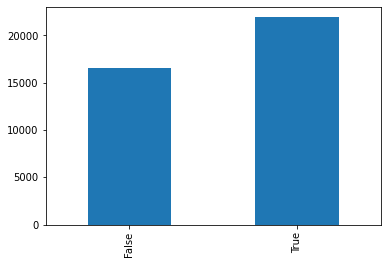

In [21]:
df['empty'].value_counts().plot.bar()

In [22]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3257
      True     4551
1.0   False    3540
      True     4540
2.0   False    3053
      True     3923
3.0   False    3407
      True     4801
4.0   False    3333
      True     4091
Name: id, dtype: int64

In [23]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df = df
        self.label = label
        self.img_paths = df['image_path'].tolist()
        self.ids = df['id'].tolist()
        if 'mask_path' in df.columns:
            self.msk_paths  = df['mask_path'].tolist()
        else:
            self.msk_paths = None
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        id_ = self.ids[index]
        img = []
        img = load_img(img_path)
        h, w = img.shape[:2]
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img), id_, h, w

In [24]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [25]:
def prepare_loaders(df, fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                             shuffle=True, drop_last=False) #  num_workers=4, 
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                               shuffle=False) # num_workers=4,
    
    return train_loader, valid_loader

In [26]:
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=CFG.backbone,     
        encoder_weights="imagenet",     
        in_channels=3,                  
        classes=CFG.num_classes,        
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [27]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss = smp.losses.DiceLoss(mode='multilabel')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
IoU_metric = smp.utils.metrics.IoU(threshold=0.5)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return BCELoss(y_pred, y_true)# + 0.5*TverskyLoss(y_pred, y_true)

In [28]:
def train_one_epoch(model, optimizer, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    tr_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss = criterion(y_pred, masks)
            loss = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            
            optimizer.zero_grad()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        #val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        tr_jaccard = IoU_metric(masks, y_pred).cpu().detach().numpy()
        tr_scores.append(tr_jaccard)
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, np.mean(tr_scores)

In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred = model(images)
        loss = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = DiceLoss(masks, y_pred).cpu().detach().numpy()
        val_jaccard = IoU_metric(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [33]:
def run_training(model, optimizer, scheduler, device, num_epochs):   
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss  = np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss, train_score = train_one_epoch(model, optimizer, #scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
        
        if scheduler is not None:
            scheduler.step(val_loss)
    
        history['Train Loss'].append(train_loss)
        history['Train IoU'].append(train_score)

        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid IoU'].append(val_jaccard)
        
        print("Logging Wandb.")
        wandb.log(
                    {
                        f"train/Loss": np.float64(train_loss),
                        f"train/IoU": np.float64(train_score),
                        f"val/Loss": np.float64(val_loss),
                        f"val/Dice": np.float64(val_dice),
                        f"val/IoU": np.float64(val_jaccard),
                    }
                    )
        
        
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        if val_loss < best_loss:
            print(f"{c_}Valid Score Improved ({best_loss:0.4f} ---> {val_loss:0.4f})")
            best_loss = val_loss
            best_jaccard = val_jaccard
            best_epoch = epoch

            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{CFG.log_path}best_model_f{fold}_ep{best_epoch}.pt"
            torch.save(model.state_dict(), PATH)      

            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"{CFG.log_path}last_epoch_f{fold}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    wandb.summary["Best Score IoU"] = np.float64(best_jaccard)
    
    model.load_state_dict(best_model_wts)
    
    return model, history


In [34]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [35]:
#for fold in range(5):
train_loader, valid_loader = prepare_loaders(df, fold=0, debug=CFG.debug)
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)
model, history = run_training(model, optimizer, scheduler,
                              device= CFG.device,
                              num_epochs=CFG.epochs)

cuda: GeForce GTX 1080 Ti



Train :   0%|          | 0/959 [00:00<?, ?it/s]

Epoch 1/10

Valid : 100%|██████████| 244/244 [01:31<00:00,  2.67it/s, gpu_memory=1.50 GB, lr=0.00200, valid_loss=0.0137]


Logging Wandb.
Valid Dice: 0.9846 | Valid Jaccard: 0.2118
Valid Score Improved (inf ---> 0.0137)


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 2/10

Valid : 100%|██████████| 244/244 [01:32<00:00,  2.65it/s, gpu_memory=1.61 GB, lr=0.00200, valid_loss=0.0085]


Logging Wandb.
Valid Dice: 0.9867 | Valid Jaccard: 0.2585
Valid Score Improved (0.0137 ---> 0.0085)


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 3/10

Valid : 100%|██████████| 244/244 [01:25<00:00,  2.84it/s, gpu_memory=1.50 GB, lr=0.00200, valid_loss=0.0072]


Logging Wandb.
Valid Dice: 0.9855 | Valid Jaccard: 0.2803
Valid Score Improved (0.0085 ---> 0.0072)


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 4/10

Valid : 100%|██████████| 244/244 [01:22<00:00,  2.95it/s, gpu_memory=1.52 GB, lr=0.00200, valid_loss=0.0072]


Logging Wandb.
Valid Dice: 0.9870 | Valid Jaccard: 0.2762


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 5/10

Valid : 100%|██████████| 244/244 [01:22<00:00,  2.95it/s, gpu_memory=1.52 GB, lr=0.00200, valid_loss=0.0072]


Logging Wandb.
Valid Dice: 0.9868 | Valid Jaccard: 0.2980
Valid Score Improved (0.0072 ---> 0.0072)


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 6/10

Valid : 100%|██████████| 244/244 [01:24<00:00,  2.89it/s, gpu_memory=1.53 GB, lr=0.00200, valid_loss=0.0069]


Logging Wandb.
Valid Dice: 0.9857 | Valid Jaccard: 0.3014
Valid Score Improved (0.0072 ---> 0.0069)


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 7/10

Valid : 100%|██████████| 244/244 [01:26<00:00,  2.84it/s, gpu_memory=1.50 GB, lr=0.00200, valid_loss=0.0072]


Logging Wandb.
Valid Dice: 0.9872 | Valid Jaccard: 0.2789


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 8/10

Valid : 100%|██████████| 244/244 [01:22<00:00,  2.95it/s, gpu_memory=1.62 GB, lr=0.00200, valid_loss=0.0070]


Logging Wandb.
Valid Dice: 0.9858 | Valid Jaccard: 0.3233


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 9/10

Valid : 100%|██████████| 244/244 [01:22<00:00,  2.95it/s, gpu_memory=1.50 GB, lr=0.00200, valid_loss=0.0075]


Logging Wandb.
Valid Dice: 0.9880 | Valid Jaccard: 0.3035


Train :   0%|          | 0/959 [00:00<?, ?it/s]



Epoch 10/10

Valid : 100%|██████████| 244/244 [02:00<00:00,  2.03it/s, gpu_memory=1.62 GB, lr=0.00200, valid_loss=0.0065]


Logging Wandb.
Valid Dice: 0.9864 | Valid Jaccard: 0.3255
Valid Score Improved (0.0069 ---> 0.0065)


Training complete in 3h 37m 50s
Best Score: 0.3255


In [36]:
wandb.finish()

train/IoU,▁▂▅▆▇▇▇▇███
train/Loss,██▂▂▂▁▁▁▁▁▁
val/Dice,▅▁▅▃▆▅▃▆▄█▅
val/IoU,▂▁▄▅▅▆▇▅█▇█
val/Loss,▃█▃▂▂▂▁▂▁▂▁
Best Score IoU,0.32555
train/IoU,0.52548
train/Loss,0.0063
val/Dice,0.98635
val/IoU,0.32555
val/Loss,0.00653
